# Introduction to PyTorch and Poutyne

In this notebook, we train a simple fully-connected network and a simple convolutional network on MNIST. First, we train it by coding our own training loop as the PyTorch library expects of us to. Then, we use Poutyne to simplify our code.

Let's import all the needed packages.

In [1]:
%matplotlib inline
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Subset
from torchvision import transforms, utils
from torchvision.datasets.mnist import MNIST

from poutyne import set_seeds
from poutyne.framework import Model

Also, we need to set Pythons's, NumPy's and PyTorch's seeds by using Poutyne function so that our training is (almost) reproducible.

In [2]:
set_seeds(42)

# Basis of Training a Neural Network

In **stochastic gradient descent**, a **batch** of `m` examples are drawn from the train dataset. In the so-called forward pass, these examples are passed through the neural network and an average of their loss values is done. In the backward pass, the average loss is backpropagated through the network to compute the gradient of each parameter. In practice, the `m` examples of a batch are drawn without replacement. Thus, we define one **epoch** of training being the number of batches needed to loop through the entire training dataset.

In addition to the training dataset, a **validation dataset** is used to evaluate the neural network at the end of each epoch. This validation dataset can be used to select the best model during training and thus avoiding overfitting the training set. It also can have other uses such as selecting hyperparameters

Finally, a **test dataset** is used at the end to evaluate the final model.

## Training constants

Now, let's set our training constants. We first have the Cuda device used for training if one is present. Secondly, we set the train_split to 0.8 (80%) to use 80% of the dataset for training and 20% for testing the trained model. Thirdly, we set the number of classes (i.e. one for each number). Finally, we set the batch size (i.e. the number of elements to see before updating the model), the learning rate for the optimizer, and the epoch number (i.e. the number of times we see the full dataset).


In [3]:
cuda_device = 0
device = torch.device("cuda:%d" % cuda_device if torch.cuda.is_available() else "cpu")

train_split_percent = 0.8

num_classes = 10

batch_size = 32
learning_rate = 0.1
num_epochs = 5

## Loading the MNIST dataset

The following loads the MNIST dataset and creates the PyTorch DataLoaders that split our datasets into batches. The train DataLoader shuffles the examples of the train dataset to draw the examples without replacement.

In [4]:
full_train_dataset = MNIST('./mnist/', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST('./mnist/', train=False, download=True, transform=transforms.ToTensor())

num_data = len(full_train_dataset)
indices = list(range(num_data))
np.random.shuffle(indices)

split = math.floor(train_split_percent * num_data)

train_indices = indices[:split]
train_dataset = Subset(full_train_dataset, train_indices)

valid_indices = indices[split:]
valid_dataset = Subset(full_train_dataset, valid_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

loaders = train_loader, valid_loader, test_loader

Let's look at some examples of the dataset by looking at the first batch in our train DataLoader and formatting it into a grid and plotting it.

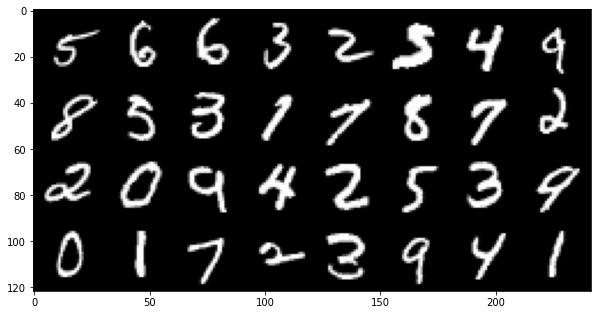

In [5]:
inputs = next(iter(train_loader))[0]
input_grid = utils.make_grid(inputs)

fig = plt.figure(figsize=(10, 10))
inp = input_grid.numpy().transpose((1, 2, 0))
plt.imshow(inp)
plt.show()

## Neural Network Architectures

We train a fully-connected neural network and a convolutional neural network with approximately the same number of parameters.

### Fully-connected Network
In short, the fully-connected network follows this architecture: ``Input -> [Linear -> ReLU]*3 -> Linear``. The following table shows it in details:

| Layer Type                  | Output Size |       # of Parameters       |
|-----------------------------|:-----------:|:---------------------------:|
| Input                       |   1x28x28   |              0              |
| Flatten                     |  1\*28\*28  |              0              |
| **Linear with 256 neurons** |     256     | 28\*28\*256 + 256 = 200,960 |
| ReLU                        |      *      |              0              |
| **Linear with 128 neurons** |     128     |   256*128 + 128 = 32,896    |
| ReLU                        |      *      |              0              |
| **Linear with 64 neurons**  |     64      |     128*64 + 64 = 8,256     |
| ReLU                        |      *      |              0              |
| **Linear with 10 neurons**  |      10     |      64*10 + 10 = 650       |

Total # of parameters of the fully-connected network: 242,762

### Convolutional Network

The convolutional neural network architecture starts with some convolution and max-pooling layers. These are then followed by fully-connected layers. We calculate the total number of parameters that the network needs. In short, the convolutional network follows this architecture: ``Input -> [Conv -> ReLU -> MaxPool]*2 -> Dropout -> Linear -> ReLU -> Dropout -> Linear``. The following table shows it in details:

| Layer Type                                     | Output Size |        # of Parameters        |
|------------------------------------------------|:-----------:|:-----------------------------:|
| Input                                          |   1x28x28   |               0               |
| **Conv with 16 3x3 filters with padding of 1** |   16x28x28  |    16\*1\*3\*3 + 16 = 160     |
| ReLU                                           |   16x28x28  |               0               |
| MaxPool 2x2                                    |   16x14x14  |               0               |
| **Conv with 32 3x3 filters with padding of 1** |   32x14x14  |   32\*16\*3\*3 + 32 = 4,640   |
| ReLU                                           |   32x14x14  |               0               |
| MaxPool 2x2                                    |    32x7x7   |               0               |
| Dropout of 0.25                                |    32x7x7   |               0               |
| Flatten                                        |   32\*7\*7  |               0               |
| **Linear with 128 neurons**                    |     128     | 32\*7\*7\*128 + 128 = 200,832 |
| ReLU                                           |     128     |               0               |
| Dropout of 0.5                                 |     128     |               0               |
| **Linear with 10 neurons**                     |      10     |        128\*10 + 10 = 1290    |

Total # of parameters of the convolutional network: 206,922

In [6]:
def create_fully_connected_network():
    """
    This function returns the fully-connected network layed out above.
    """
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, num_classes)
    )

def create_convolutional_network():
    """
    This function returns the convolutional network layed out above.
    """
    return nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(0.25),
        nn.Flatten(),
        nn.Linear(32*7*7, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, num_classes)
    )

# Training the PyTorch way 

That is, doing your own training loop.

In [7]:
def pytorch_accuracy(y_pred, y_true):
    """
    Computes the accuracy for a batch of predictions
    
    Args:
        y_pred (torch.Tensor): the logit predictions of the neural network.
        y_true (torch.Tensor): the ground truths.
        
    Returns:
        The average accuracy of the batch.
    """
    y_pred = y_pred.argmax(1)
    return (y_pred == y_true).float().mean() * 100

def pytorch_train_one_epoch(pytorch_network, optimizer, loss_function):
    """
    Trains the neural network for one epoch on the train DataLoader.
    
    Args:
        pytorch_network (torch.nn.Module): The neural network to train.
        optimizer (torch.optim.Optimizer): The optimizer of the neural network
        loss_function: The loss function.
    
    Returns:
        A tuple (loss, accuracy) corresponding to an average of the losses and
        an average of the accuracy, respectively, on the train DataLoader.
    """
    pytorch_network.train(True)
    with torch.enable_grad():
        loss_sum = 0.
        acc_sum = 0.
        example_count = 0
        for (x, y) in train_loader:
            # Transfer batch on GPU if needed.
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()

            y_pred = pytorch_network(x)

            loss = loss_function(y_pred, y)

            loss.backward()

            optimizer.step()

            # Since the loss and accuracy are averages for the batch, we multiply 
            # them by the the number of examples so that we can do the right 
            # averages at the end of the epoch.
            loss_sum += float(loss) * len(x)
            acc_sum += float(pytorch_accuracy(y_pred, y)) * len(x)
            example_count += len(x)

    avg_loss = loss_sum / example_count
    avg_acc = acc_sum / example_count
    return avg_loss, avg_acc

def pytorch_test(pytorch_network, loader, loss_function):
    """
    Tests the neural network on a DataLoader.
    
    Args:
        pytorch_network (torch.nn.Module): The neural network to test.
        loader (torch.utils.data.DataLoader): The DataLoader to test on.
        loss_function: The loss function.
    
    Returns:
        A tuple (loss, accuracy) corresponding to an average of the losses and
        an average of the accuracy, respectively, on the DataLoader.
    """
    pytorch_network.eval()
    with torch.no_grad():
        loss_sum = 0.
        acc_sum = 0.
        example_count = 0
        for (x, y) in loader:
            # Transfer batch on GPU if needed.
            x = x.to(device)
            y = y.to(device)
            
            y_pred = pytorch_network(x)
            loss = loss_function(y_pred, y)

            # Since the loss and accuracy are averages for the batch, we multiply 
            # them by the the number of examples so that we can do the right 
            # averages at the end of the test.
            loss_sum += float(loss) * len(x)
            acc_sum += float(pytorch_accuracy(y_pred, y)) * len(x)
            example_count += len(x)
    
    avg_loss = loss_sum / example_count
    avg_acc = acc_sum / example_count
    return avg_loss, avg_acc
        
    
def pytorch_train(pytorch_network):   
    """
    This function transfers the neural network to the right device, 
    trains it for a certain number of epochs, tests at each epoch on
    the validation set and outputs the results on the test set at the
    end of training.
    
    Args:
        pytorch_network (torch.nn.Module): The neural network to train.
        
    Example:
        This function displays something like this:
        
        .. code-block:: python

            Epoch 1/5: loss: 0.5026924496193726, acc: 84.26666259765625, val_loss: 0.17258917854229608, val_acc: 94.75
            Epoch 2/5: loss: 0.13690324830015502, acc: 95.73332977294922, val_loss: 0.14024296019474666, val_acc: 95.68333435058594
            Epoch 3/5: loss: 0.08836929737279813, acc: 97.29582977294922, val_loss: 0.10380942322810491, val_acc: 96.66666412353516
            Epoch 4/5: loss: 0.06714504160980383, acc: 97.91874694824219, val_loss: 0.09626663728555043, val_acc: 97.18333435058594
            Epoch 5/5: loss: 0.05063822727650404, acc: 98.42708587646484, val_loss: 0.10017542181412378, val_acc: 96.95833587646484
            Test:
                Loss: 0.09501855444908142
                Accuracy: 97.12999725341797
    """
    print(pytorch_network)
    
    # Transfer weights on GPU if needed.
    pytorch_network.to(device)
    
    optimizer = optim.SGD(pytorch_network.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()
    
    for epoch in range(1, num_epochs + 1):
        # Training the neural network via backpropagation
        train_loss, train_acc = pytorch_train_one_epoch(pytorch_network, optimizer, loss_function)
        
        # Validation at the end of the epoch
        valid_loss, valid_acc = pytorch_test(pytorch_network, valid_loader, loss_function)

        print("Epoch {}/{}: loss: {}, acc: {}, val_loss: {}, val_acc: {}".format(
            epoch, num_epochs, train_loss, train_acc, valid_loss, valid_acc
        ))
    
    # Test at the end of the training
    test_loss, test_acc = pytorch_test(pytorch_network, test_loader, loss_function)
    print('Test:\n\tLoss: {}\n\tAccuracy: {}'.format(test_loss, test_acc))

In [8]:
fc_net = create_fully_connected_network()
pytorch_train(fc_net)

Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=64, bias=True)
  (6): ReLU()
  (7): Linear(in_features=64, out_features=10, bias=True)
)
Epoch 1/5: loss: 0.5027033858584861, acc: 84.26666666666667, val_loss: 0.17308224300046762, val_acc: 94.70833333333333
Epoch 2/5: loss: 0.13664239076307663, acc: 95.75833333333334, val_loss: 0.14514247783025105, val_acc: 95.60833333333333
Epoch 3/5: loss: 0.08835018526824812, acc: 97.25, val_loss: 0.10308833610452711, val_acc: 96.66666666666667
Epoch 4/5: loss: 0.0668404719455478, acc: 97.94166666666666, val_loss: 0.10181141934109231, val_acc: 96.90833333333333
Epoch 5/5: loss: 0.05007533495815005, acc: 98.45833333333333, val_loss: 0.09903668748401105, val_acc: 97.01666666666667
Test:
	Loss: 0.09028350643445737
	Accuracy: 97.24


In [9]:
conv_net = create_convolutional_network()
pytorch_train(conv_net)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Dropout(p=0.25, inplace=False)
  (7): Flatten()
  (8): Linear(in_features=1568, out_features=128, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=128, out_features=10, bias=True)
)


KeyboardInterrupt: 

# Training the Poutyne way

That is, only 8 lines of code with a better output.

In [ ]:
def poutyne_train(pytorch_network):
    """
    This function creates a Poutyne Model (see https://poutyne.org/model.html), sends the Model
    on the specified device, and uses the `fit_generator` method to train the neural network. 
    At the end, the `evaluate_generator` is used on  the test set.
    
    Args:
        pytorch_network (torch.nn.Module): The neural network to train.
    """
    print(pytorch_network)
    
    optimizer = optim.SGD(pytorch_network.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()

    # Poutyne Model
    model = Model(pytorch_network, optimizer, loss_function, batch_metrics=['accuracy'])

    # Send model on GPU
    model.to(device)

    # Train
    model.fit_generator(train_loader, valid_loader, epochs=num_epochs)

    # Test
    test_loss, test_acc = model.evaluate_generator(test_loader)
    print('Test:\n\tLoss: {}\n\tAccuracy: {}'.format(test_loss, test_acc))

In [ ]:
fc_net = create_fully_connected_network()
poutyne_train(fc_net)

In [ ]:
conv_net = create_convolutional_network()
poutyne_train(conv_net)